In [1]:
from flow.flow import Sequential
from flow.conditioner import MADE
from flow.transformer import DSF
from flow.modules import BatchNorm
from flow.training import get_device, train, plot_losses, test_nll

import matplotlib.pyplot as plt # used for plotting flow samples later

Let's generate some synthetic data for this example.

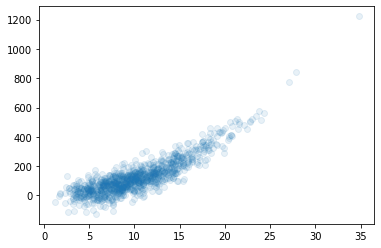

In [2]:
# Define trainX, valX, testX
import numpy as np
import torch

# Set seeds for reproducibility
np.random.seed(123) 
torch.random.manual_seed(123)

x = np.random.chisquare(10, size=1000)
y = x ** 2 + np.random.normal(size=1000) * 50
X = torch.Tensor(np.stack([x, y], 1))

trainX, valX, testX = X[:800], X[800:900], X[900:]

plt.scatter(*X.numpy().T, alpha=.1);

Create the flow, train it, plot its loss evolution and compute the test loss.

690it [01:23,  8.28it/s, current_loss=8.42, best_epoch=590, best_loss=8.29]


8.378586113452911

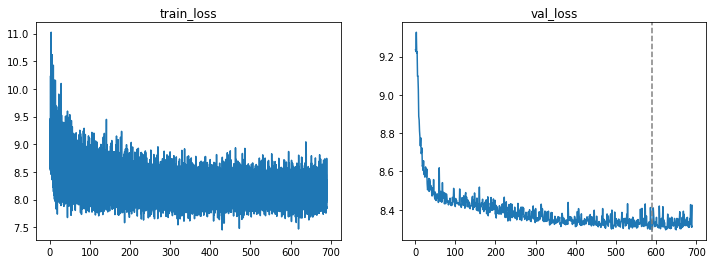

In [3]:
dim = trainX.size(1) # dimension of the flow

device = get_device() # cuda if available, cpu otherwise

# X transformed to base distribution U, like so:
# X -> BatchNorm -> MADE-DSF -> BatchNorm -> MADE-DSF -> U
flow = Sequential(
    BatchNorm(dim=dim), # we use BatchNorm for training stabilization
    MADE(DSF(dim=dim)), # combines a MADE conditioner with an Affine transformer
    
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim))
).to(device) # don't forget to send it to device

# Train the flow with the train function, but you can use your own.
# train uses early stopping, that's why we need a validation set.
train_losses, val_losses = train(flow, trainX, valX)

# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Compute the test set negative log-likelihood (the loss function used for training)
test_nll(flow, testX)

Plot some samples to see if they reflect the real distribution.

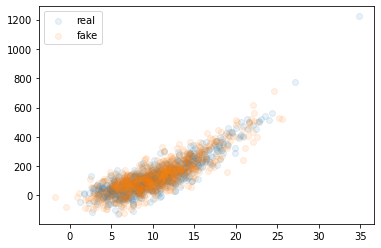

In [4]:
with torch.no_grad():
    sample = flow.sample(trainX.size(0))
    sample = sample.cpu().numpy() # to numpy array
    
plt.scatter(*trainX.numpy().T, alpha=.1, label='real')
plt.scatter(*sample.T, alpha=.1, label='fake')
plt.legend();